<a href="https://colab.research.google.com/github/anbalaji/datasharing/blob/master/TimeGAN_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
#@title
sns.set_style('white')

In [5]:
np.random.seed(42)
tf.random.set_seed(1234)

# Experiment Path

In [7]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [8]:
experiment = 0

In [9]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [ ]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# Prepare Data

In [10]:
df = pd.read_csv('https://raw.githubusercontent.com/stefan-jansen/synthetic-data-for-finance/main/stocks.csv', 
                 index_col='date', 
                 parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4586 entries, 2000-01-03 to 2018-03-27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BA      4586 non-null   float64
 1   CAT     4586 non-null   float64
 2   DIS     4586 non-null   float64
 3   GE      4586 non-null   float64
 4   IBM     4586 non-null   float64
 5   KO      4586 non-null   float64
dtypes: float64(6)
memory usage: 250.8 KB


## Parameters

In [11]:
seq_len = 24
n_seq = 6
batch_size = 128

In [13]:
tickers = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']

## Plot Series

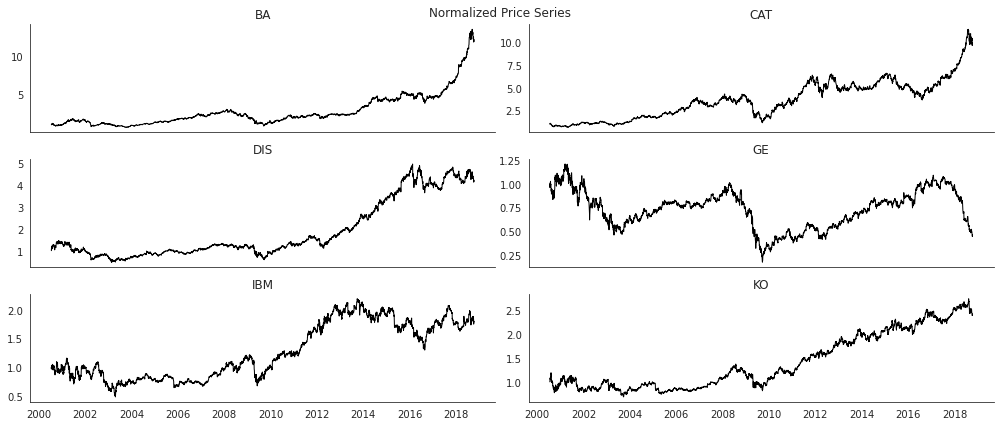

In [14]:
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=tickers,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine();

## Correlation

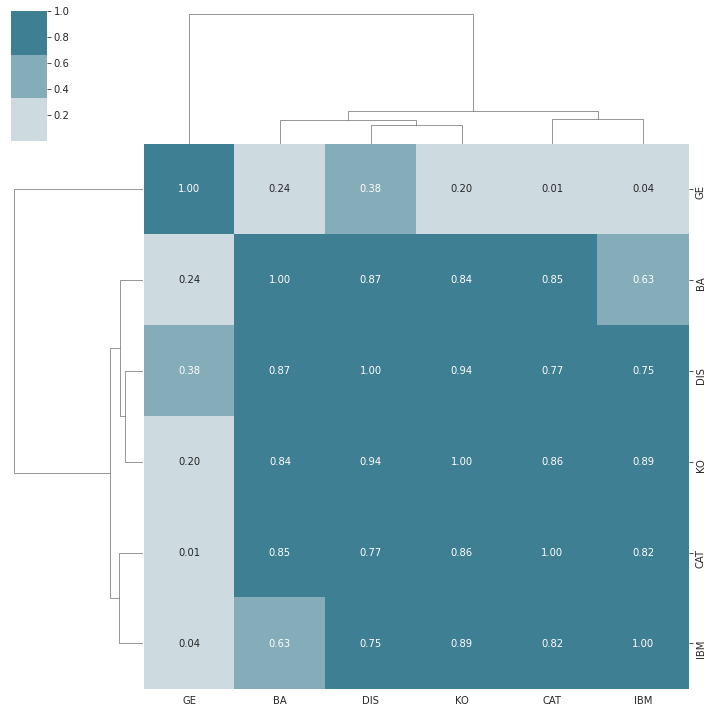

In [ ]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

In [15]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [ ]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

## Create tf.data.Dataset

In [ ]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [ ]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [ ]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [ ]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [ ]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [ ]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [ ]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [ ]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [ ]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [ ]:
# train_steps = 100
# more train steps to get a better result
train_steps = 10000
gamma = 1

## Generic Loss Functions

In [ ]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [ ]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [ ]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            10104     
_________________________________________________________________
Recovery (Sequential)        (None, 24, 6)             10950     
Total params: 21,054
Trainable params: 21,054
Non-trainable params: 0
_________________________________________________________________


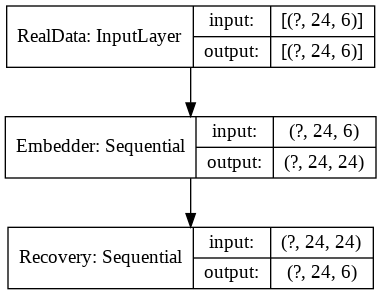

In [ ]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

## Autoencoder Optimizer

In [ ]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [ ]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [01:57<00:00, 85.25it/s]


## Persist model

In [ ]:
# autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

## Define Optimizer

In [ ]:
supervisor_optimizer = Adam()

## Train Step

In [ ]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [05:25<00:00, 30.76it/s]


## Persist Model

In [ ]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [ ]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [ ]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10104     
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 28,729
Trainable params: 28,729
Non-trainable params: 0
_________________________________________________________________


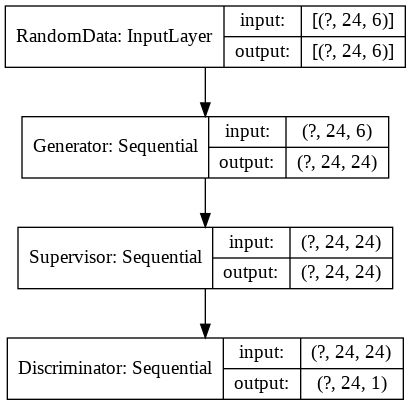

In [ ]:
plot_model(adversarial_supervised, show_shapes=True)

### Adversarial Architecture in Latent Space

In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [ ]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10104     
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


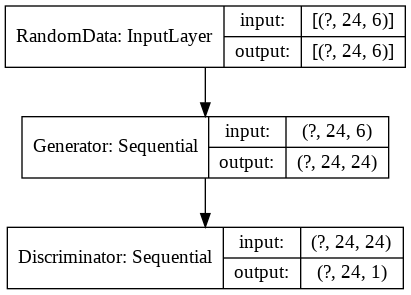

In [ ]:
plot_model(adversarial_emb, show_shapes=True)

### Mean & Variance Loss

In [ ]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [ ]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10104     
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Recovery (Sequential)        (None, 24, 6)             10950     
Total params: 28,854
Trainable params: 28,854
Non-trainable params: 0
_________________________________________________________________


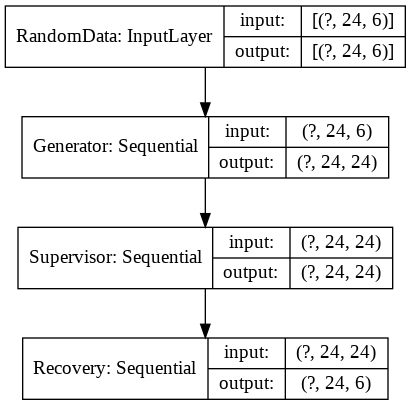

In [ ]:
plot_model(synthetic_data, show_shapes=True)

In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [ ]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [ ]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            10104     
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


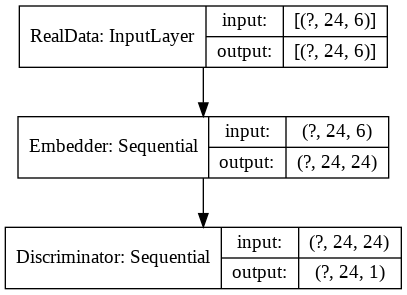

In [ ]:
plot_model(discriminator_model, show_shapes=True)

## Optimizers

In [ ]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [ ]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [ ]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.1400 | g_loss_u: 0.6475 | g_loss_s: 0.0004 | g_loss_v: 0.3164 | e_loss_t0: 0.0479
 1,000 | d_loss: 1.4856 | g_loss_u: 1.2562 | g_loss_s: 0.0001 | g_loss_v: 0.0389 | e_loss_t0: 0.0151
 2,000 | d_loss: 1.4931 | g_loss_u: 1.3418 | g_loss_s: 0.0001 | g_loss_v: 0.0274 | e_loss_t0: 0.0135
 3,000 | d_loss: 1.6174 | g_loss_u: 1.3868 | g_loss_s: 0.0001 | g_loss_v: 0.0193 | e_loss_t0: 0.0135
 4,000 | d_loss: 1.5822 | g_loss_u: 1.3596 | g_loss_s: 0.0002 | g_loss_v: 0.0501 | e_loss_t0: 0.0117
 5,000 | d_loss: 1.5395 | g_loss_u: 1.4036 | g_loss_s: 0.0001 | g_loss_v: 0.0214 | e_loss_t0: 0.0108
 6,000 | d_loss: 1.5829 | g_loss_u: 1.4971 | g_loss_s: 0.0001 | g_loss_v: 0.0398 | e_loss_t0: 0.0102
 7,000 | d_loss: 1.6469 | g_loss_u: 1.5249 | g_loss_s: 0.0001 | g_loss_v: 0.0203 | e_loss_t0: 0.0102
 8,000 | d_loss: 1.4624 | g_loss_u: 1.6115 | g_loss_s: 0.0001 | g_loss_v: 0.0654 | e_loss_t0: 0.0085
 9,000 | d_loss: 1.4824 | g_loss_u: 1.5012 | g_loss_s: 0.0001 | g_loss_v: 0.0405 | e_loss_t

## Persist Synthetic Data Generator

In [ ]:
synthetic_data.save(log_dir / 'synthetic_data')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


# Generate Synthetic Data

In [ ]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)

35

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(4480, 24, 6)

In [ ]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

In [ ]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(4480, 24, 6)

## Persist Data

In [ ]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot sample Series

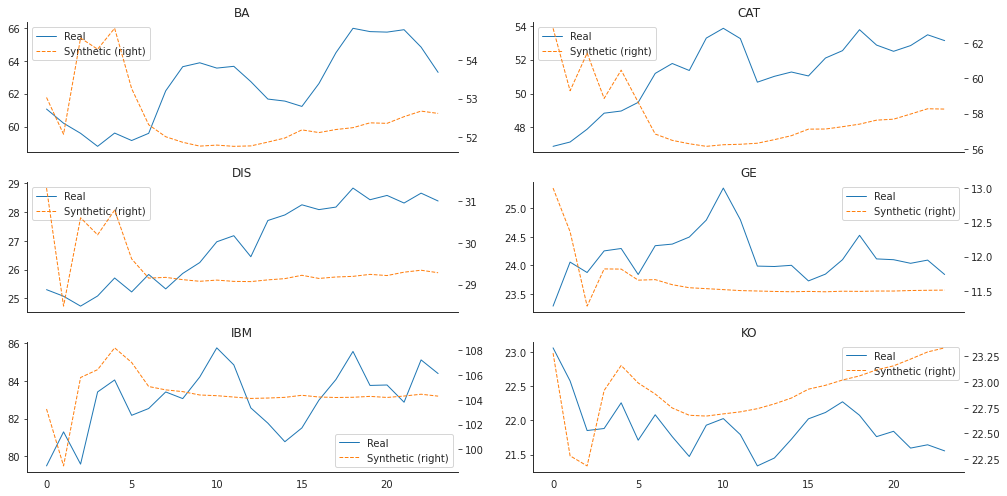

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

<font size="+3">Visualize Real and Synthetic Data</font>

# Load Data

In [ ]:
def get_real_data():
    df = pd.read_csv('https://raw.githubusercontent.com/stefan-jansen/synthetic-data-for-finance/main/stocks.csv', 
                     index_col='date', 
                     parse_dates=['date']).sort_index()

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data


real_data = get_real_data()

In [ ]:
n = len(real_data)

In [ ]:
np.asarray(real_data).shape

(4562, 24, 6)

In [ ]:
synthetic_data = np.load(results_path / f'experiment_{experiment:02d}' / 'generated_data.npy')
synthetic_data.shape

(4480, 24, 6)

In [ ]:
real_data = real_data[:synthetic_data.shape[0]]

# Prepare Sample

In [ ]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [ ]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [ ]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [ ]:
real_sample_2d.shape, synthetic_sample_2d.shape

((1500, 24), (1500, 24))

# Visualization in 2D: A Qualitative Assessment of Diversity

## Run PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

## Run t-SNE

In [ ]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.009s...
[t-SNE] Computed neighbors for 3000 samples in 0.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.071400
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.394547
[t-SNE] KL divergence after 1000 iterations: 0.311831


In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

## Plot Result

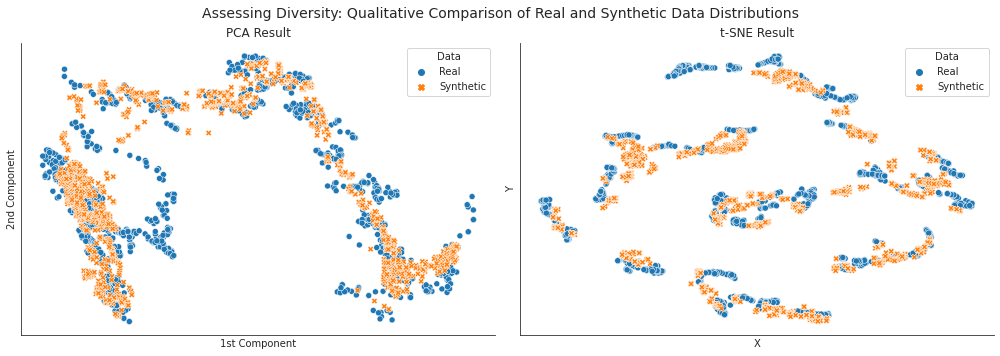

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Time Series Classification: A quantitative Assessment of Fidelity

## Prepare Data

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(4480, 24, 6)

In [ ]:
synthetic_data.shape

(4480, 24, 6)

In [ ]:
n_series = real_data.shape[0]

In [ ]:
idx = np.arange(n_series)

In [ ]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [ ]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [ ]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

## Create Classifier

In [ ]:
ts_classifier = Sequential([GRU(6, input_shape=(24, 6), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [ ]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [ ]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, 6)                 252       
_________________________________________________________________
OUT (Dense)                  (None, 1)                 7         
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [ ]:
ts_classifier.evaluate(x=test_data, y=test_labels)

56/56 [==============================] - 0s 3ms/step - loss: 2.1185 - AUC: 0.1438 - accuracy: 0.4598


[2.1184773445129395, 0.14384803175926208, 0.4598214328289032]

In [ ]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [ ]:
from matplotlib.ticker import FuncFormatter

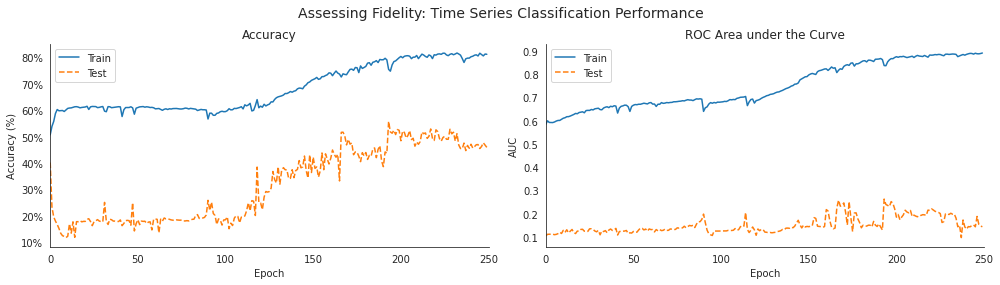

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# Train on Synthetic, test on real: Assessing usefulness

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [ ]:
real_data.shape, synthetic_data.shape

((4480, 24, 6), (4480, 24, 6))

In [ ]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [ ]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((3584, 23, 6), (3584, 6), (896, 23, 6), (896, 6))

In [ ]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [ ]:
synthetic_train.shape, synthetic_label.shape

((4480, 23, 6), (4480, 6))

In [ ]:
def get_model():
    model = Sequential([GRU(12, 
                            input_shape=(seq_len-1, 
                                         n_seq)),
                        Dense(6)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [ ]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [ ]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 
                                                                          'val_loss': 'Test'})

In [ ]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [ ]:
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 
                                                                'val_loss': 'Test'})

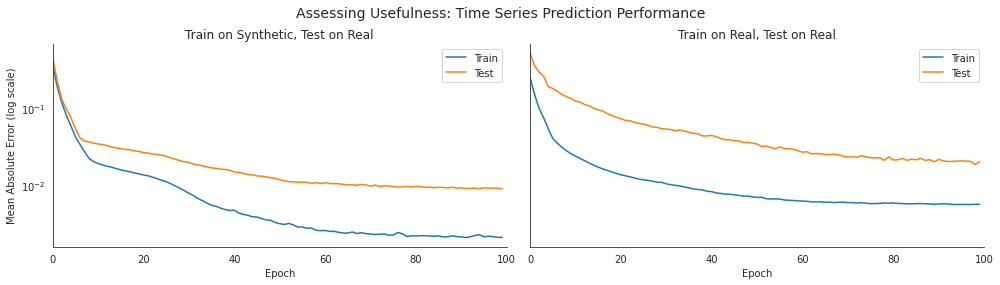

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', 
                      logy=True, 
                      xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', 
                 logy=True, 
                 xlim=(0, 100))

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);